20191204 having one last go at the g140m extractions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
#from craftroom import resample
import stistools

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [3]:
datapath = 'raw_data/'
outpath = 'new_x1ds/'
flts = glob.glob(datapath + '*flt.fits*')
oref="${CRDS_PATH}/references/hst/oref/"


In [5]:
#check it works
#stistools.x1d.x1d(flts[0], output=outpath+"test", verbose=True, trailer=outpath+"test.trl")

Appending to trailer file new_x1ds/test.trl
Running x1d on raw_data/oddv01030_flt.fits
  ['cs6.e', 'raw_data/oddv01030_flt.fits', 'new_x1ds/test', '-v', '-back', '-cte', '-disp', '-hel', '-flux', '-bm', '-bo', '3', '-a', 'unweighted']


0

In [7]:
#data = fits.getdata(outpath+'test.fits')
#plt.plot(data[0]['WAVELENGTH'], data[0]['FLUX'])

In [15]:
centab = Table.read('new_trace_centers.ecsv')
centab

ROOTNAME,XCOL,A2CENTER,UNCERTAIN
str9,float64,float64,float64
oddv01030,397.5643857974539,174.42706993478942,0.0
odhsf1020,394.4548939298936,177.0758834973367,0.0
odhs16030,394.4548939298936,182.98618900332974,0.0
odhs16010,394.4548939298936,181.37428750169533,0.0
odhs30030,391.7683914271695,185.13539100550906,0.0
odhs05030,394.9921944304384,179.225085499516,0.0
odhs05010,395.5294949309832,176.5385829967919,0.0
odhs31070,392.3056919277143,185.13539100550906,0.0
odhs30040,391.2310909266247,186.74729250714347,0.0


In [34]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center


In [40]:
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

for i, flt in enumerate(flts):
    hdr = fits.getheader(flt, 0)
    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
    rootname =  hdr['ROOTNAME']
    if rootname in centab['ROOTNAME']:
        rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
        if centab['UNCERTAIN'][rootarg] == 0.0:
            #adjust measured a2 center to central point
            x = centab['XCOL'][rootarg]
            y = centab['A2CENTER'][rootarg]
            a2center = get_a2center(x,y, tracegrid)
            stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=False, trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0)
   

In [41]:
#grab the current state of the art...
cspec = Table.read('extracted_spectra/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g140m_v1_component-spec.ecsv')
wc, fc, ec = cspec['WAVELENGTH'], cspec['FLUX'], cspec['ERROR']

83


(1212, 1218)

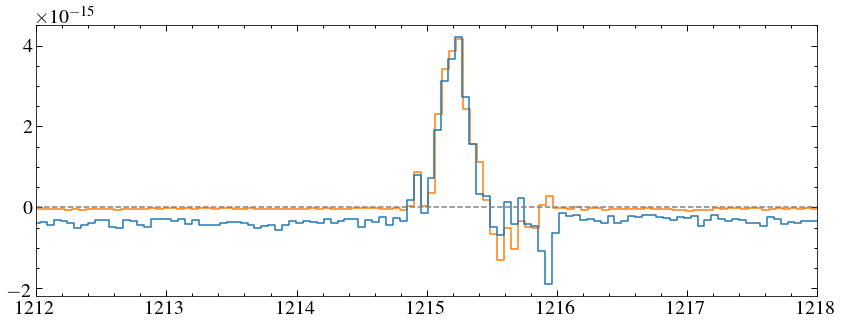

In [44]:
def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

f_new = []
e_new = []

new_x1ds = glob.glob(outpath+'*new_x1d*')
print(len(new_x1ds))
for i, x in enumerate(new_x1ds):
        data = fits.getdata(x, 1)[0]
        if i == 0:
            w_new = data['WAVELENGTH']
           # w_new = np.arange(w_new[5], w_new[-6], np.mean(np.diff(w_new)))
            f_new.append(data['FLUX'])
            e_new.append(data['ERROR'])
        else:
            fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
            f_new.append(fi)
            ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
            e_new.append(ei)

f_new, e_new = new_coadd(np.array(f_new), np.array(e_new))
plt.step(w_new, f_new, where='mid')
plt.step(wc, fc, where='mid', zorder=-1)
plt.axhline(0, ls='--', c='0.5')
plt.xlim(1212, 1218)